### Import jax libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.nn import relu, tanh, sigmoid

from jax.example_libraries import optimizers

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

### Load Data

In [2]:
# data path
filedir = '/Users/simoncharpigny/Documents/data_aurore/'
filename='data_learning.npz'

In [3]:
data = np.load(filedir+filename,allow_pickle=True)
print('files =', data.files)

Lambda_Train = jnp.array(data['Lambda_Train'])[:,:,0]
Lambda_Test = jnp.array(data['Lambda_Test'])[:,:,0]
param_train = data['param_train'][()]
param_test = data['param_test'][()]

param_train = {'Ecllat' : param_train.get('EclLat')}
param_test = {'EclLat' : param_test.get('EclLat')}

# create an array version of the dict
param_train_matrix = jnp.transpose(jnp.array([param_train.get(k) for k in param_train.keys()]))
param_test_matrix = jnp.transpose(jnp.array([param_test.get(k) for k in param_test.keys()]))    

print('Nentrées, Nlambda =', Lambda_Train.shape)
print('paramètres = ', param_train.keys())

files = ['Lambda_Train', 'Lambda_Test', 'param_train', 'param_test']
Nentrées, Nlambda = (5000, 28)
paramètres =  dict_keys(['Ecllat'])


### Create modele architecture

In [4]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

Nx = Lambda_Train.shape[0]
Nlambda = Lambda_Train.shape[1]
Nparam = len(param_train.keys())
layer_sizes = [Nlambda, int(Nlambda*3/4), int(Nlambda*1/4), Nparam]
print(layer_sizes)


# Return a list of tuples of layer weights
params_init = initialize_mlp(layer_sizes, key)

[28, 21, 7, 1]


### Write model inner functions

In [5]:
@jit
def tanh_layer(params, x):
    """ Simple tanh layer for single sample """
    return tanh(jnp.dot(params[0], x) + params[1])

@jit
def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return relu(jnp.dot(params[0], x) + params[1])

In [6]:
@jit
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = tanh_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    y = jnp.dot(final_w, activations) + final_b
    
    return y

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)


In [7]:
def loss(params, in_array, target):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_array)
    MSE = jnp.sum(jnp.square(preds-target))/preds.shape[0]
    return MSE


In [8]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value = loss(params, x, y)
    grads = grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [9]:
@jit
def dist(params, in_array, target):
    """ Compute a metric function for a provided x and target batch """
    preds = batch_forward(params, in_array)
    MSE = jnp.sum(jnp.square(preds-target), axis = 0)/preds.shape[0]
    #RMSE = np.sqrt(MSE)
    return MSE    

### Train the model

In [10]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_init)

num_epochs = 1000
batch_len = 200


In [11]:
def run_training_loop(param_train_mat, param_test_mat, num_epochs, batch_len, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize the test and training set and the batch parameters
    epoch_keys = random.split(key, num_epochs)
    N_batch = Lambda_Test.shape[0]//batch_len
    
    # Initialize placeholder for loggin
    log_dist_train, log_dist_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)
    
    # Loop over the training epochs
    for epoch in range(num_epochs):
        
        #randomization of the lambda train and params train
        rd_Lambda_Train = random.permutation(epoch_keys[epoch],Lambda_Train, axis=0)
        rd_param_train_mat = random.permutation(epoch_keys[epoch],param_train_mat, axis=0)
        
        epoch_loss = 0
        for k in range (0,N_batch):
            x = rd_Lambda_Train[k*batch_len:(k+1)*batch_len,:]
            y = rd_param_train_mat[k*batch_len:(k+1)*batch_len,:]
            params, opt_state, loss_value = update(params, x, y, opt_state)
            epoch_loss += loss_value
                
        epoch_loss /= N_batch
        train_loss.append(epoch_loss)

        train_dist = dist(params, Lambda_Train, param_train_mat)
        test_dist = dist(params, Lambda_Test, param_test_mat)
        
        log_dist_train.append(train_dist)
        log_dist_test.append(test_dist)

    preds = batch_forward(params, Lambda_Test)
    
    return train_loss, np.array(log_dist_train), np.array(log_dist_test), np.array(preds), params
    

train_loss, train_log, test_log, preds, params_f = run_training_loop(param_train_matrix, param_test_matrix, num_epochs, batch_len, opt_state)


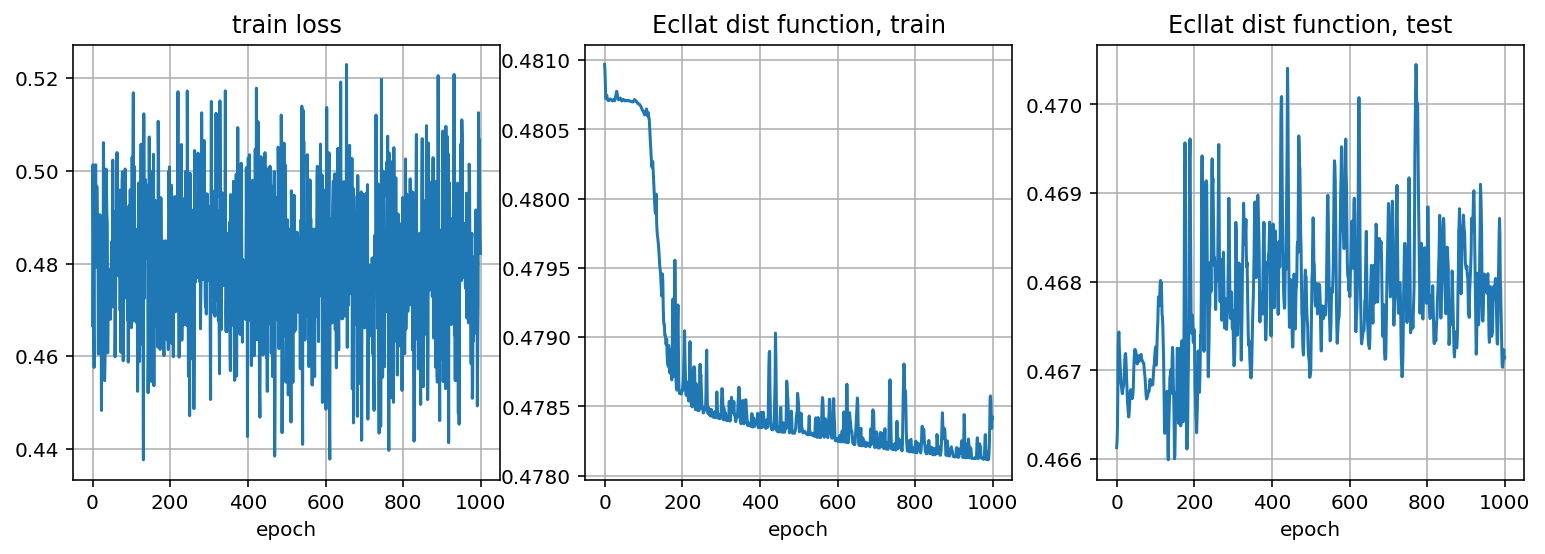

In [12]:
plt.figure(figsize=(13,4))

#loss
plt.subplot(131)
plt.plot(train_loss)
plt.grid()
plt.title(r'train loss')
plt.xlabel('epoch')

#train
plt.subplot(132)
plt.plot(train_log, color = 'C0')
plt.grid()
plt.title(list(param_train.keys())[0]+' dist function, train')
plt.xlabel('epoch')


#test
plt.subplot(133)
plt.plot(test_log, color = 'C0')
plt.title(list(param_train.keys())[0]+' dist function, test')
plt.grid()
plt.xlabel('epoch')


plt.show()



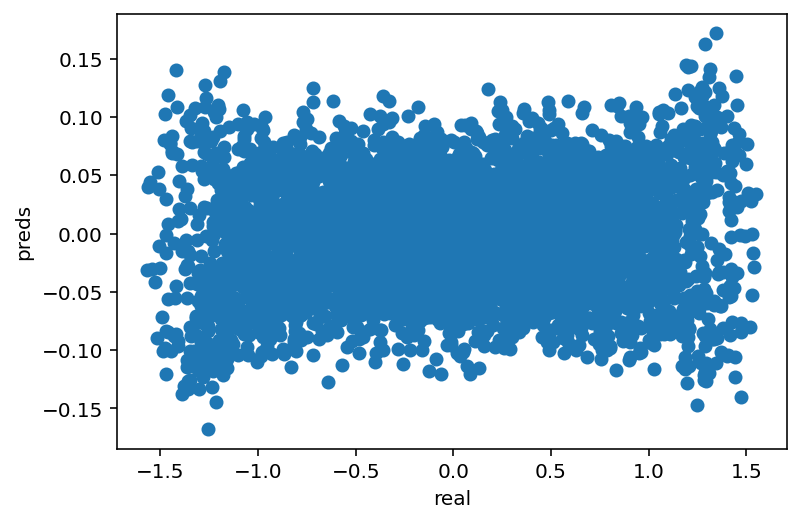

In [13]:
in_array = Lambda_Train
preds = batch_forward(params_f, in_array)
plt.scatter(param_train_matrix, preds)
plt.ylabel('preds')
plt.xlabel('real')
plt.show()